In [1]:
%cd ..

d:\Linux\10_DRL\Code\Project\Final_Word-level


In [2]:
%ls

 Volume in drive D is Mjnk
 Volume Serial Number is 5A8E-8B70

 Directory of d:\Linux\10_DRL\Code\Project\Final_Word-level

06/19/2024  05:49 AM    <DIR>          .
06/16/2024  10:56 PM    <DIR>          ..
04/05/2024  08:52 PM                 0 __init__.py
06/27/2024  07:50 PM    <DIR>          Data
06/27/2024  08:48 PM    <DIR>          Images
07/01/2024  07:45 PM    <DIR>          Model
06/27/2024  09:12 PM    <DIR>          Notebook
06/03/2024  07:48 PM               136 requirement.txt
06/10/2024  04:41 PM    <DIR>          src
               2 File(s)            136 bytes
               7 Dir(s)  96,353,509,376 bytes free


In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import tqdm

import torch
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report

from src.utils import *
from src.model import *
from src.env import *

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device:', device)

c:\Users\royal\miniconda3\envs\ml\lib\site-packages\transformers\utils\generic.py:481: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\royal\miniconda3\envs\ml\lib\site-packages\transformers\utils\generic.py:338: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\royal\miniconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads 

Current device: cuda


# Import data

In [4]:
try: 
    print('Loading processed data...')
    data = pd.read_csv('./Data/Processed/E_Commerce_review.csv')
    print('Data loaded successfully.')
except:
    print('Processed data not found. Loading raw data and preprocessing...')
    data = pd.read_csv('./Data/Raw/E_Commerce_review.csv')
    data = preprocessing_data(data)
    print('Data loaded and preprocessed successfully.')

data.describe()

Loading processed data...
Data loaded successfully.


,rating
count,38672.000000
mean,0.975719
std,0.837872
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [5]:
data.head()

,content,rating
0,khiếp giao hàng lâu thực_sự luôn ấy . điều_kiệ...,2
1,sản_phẩm cùi bắp giá tiền . cân mua trái_cây k...,1
2,áo ngắn mặc,1
3,may minh_điên . kỹ_thuật liên_hệ bảo_hành,2
4,hoạt_động chức_năng ổn_định suốt 1 trục_trặc !,2


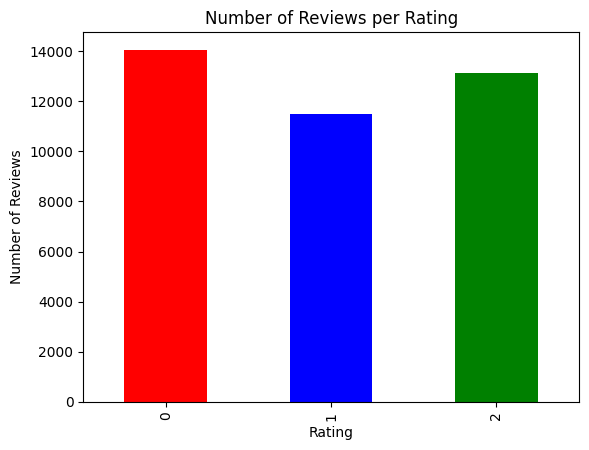

In [6]:
data['rating'].value_counts().sort_index().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Rating')
plt.show()

In [7]:
data['rating'].value_counts()

rating
0    14055
2    13116
1    11501
Name: count, dtype: int64

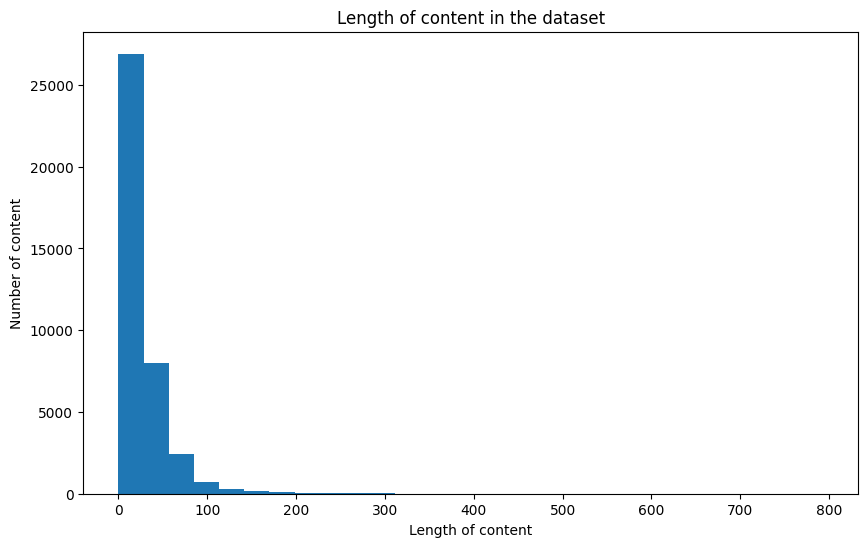

count    38672.000000
mean        26.013084
std         28.757844
min          1.000000
25%          9.000000
50%         17.000000
75%         33.000000
max        793.000000
Name: content, dtype: float64


In [8]:
content_lengths = data['content'].apply(lambda x: len(x.split()))
content_lengths.plot(kind='hist', bins=int(content_lengths.std()), range=(0, int(content_lengths.max())), figsize=(10, 6))
plt.xlabel('Length of content')
plt.ylabel('Number of content')
plt.title('Length of content in the dataset')
plt.show()

print(content_lengths.describe())

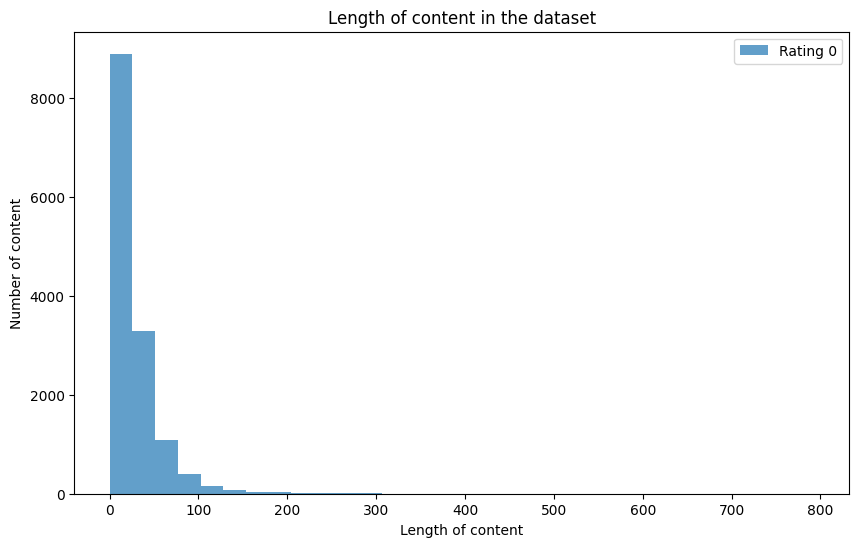

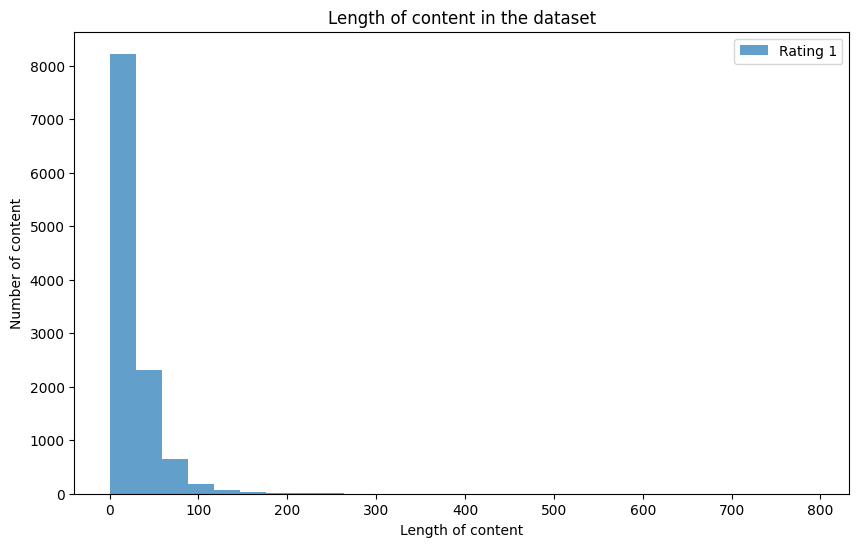

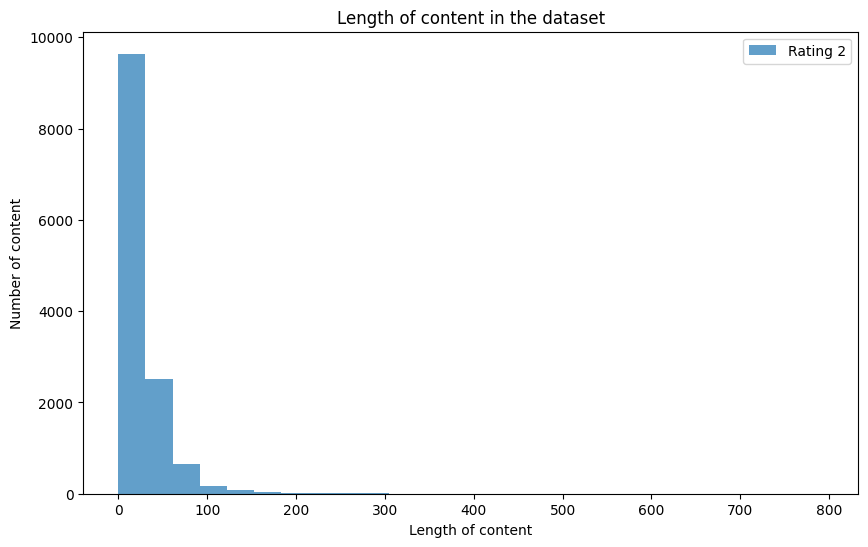

In [9]:
data['content_length'] = data['content'].apply(lambda x: len(x.split()))

for i in range(len(data['rating'].unique())):
    plt.figure(figsize=(10, 6))
    length_bins = int(data[data['rating'] == i]['content_length'].std())
    plt.hist(data[data['rating'] == i]['content_length'], bins=length_bins, alpha=0.7, label=f'Rating {i}', range=(0, int(content_lengths.max())))
    plt.xlabel('Length of content')
    plt.ylabel('Number of content')
    plt.title('Length of content in the dataset')
    plt.legend()
    plt.show()

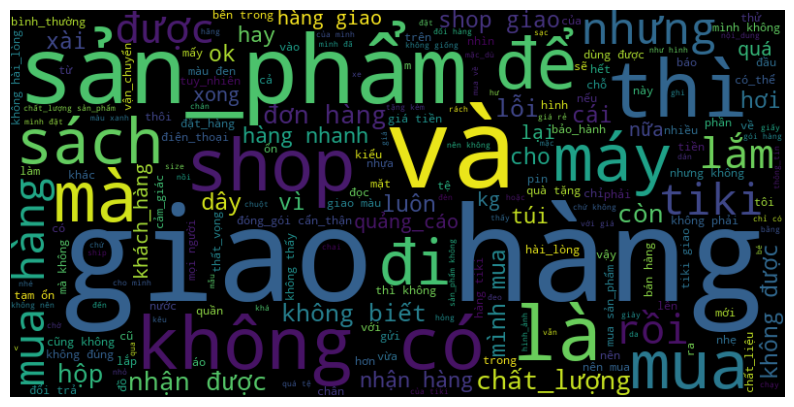

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(data['content']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Number of words in the dataset: 31157


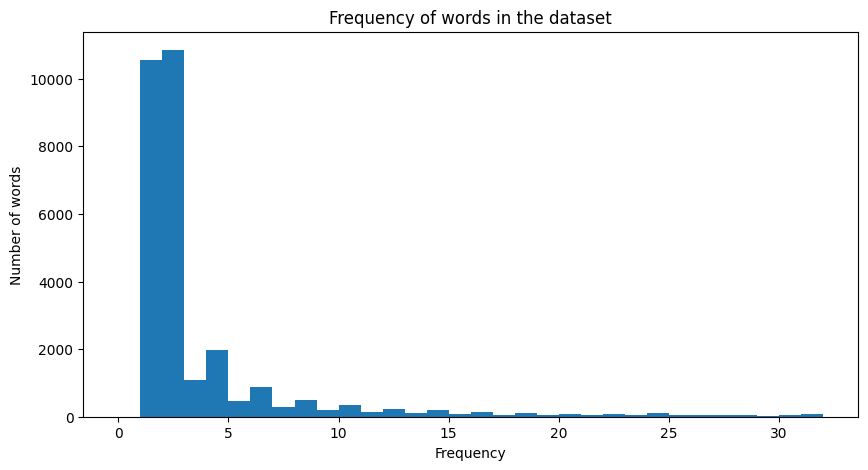

count    31157.000000
mean        32.287383
std        558.646175
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max      61650.000000
Name: frequency, dtype: float64


In [11]:
num_words = len(set(' '.join(data['content']).split()))
print('Number of words in the dataset:', num_words)

word_freq = Counter(' '.join(data['content']).split()).most_common(num_words)
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])
word_freq_df['frequency'] = word_freq_df['frequency'].astype(int)
bins = int(word_freq_df['frequency'].mean())

word_freq_df['frequency'].plot(kind='hist', bins=bins, range=(0, bins), figsize=(10, 5))
plt.xlabel('Frequency')
plt.ylabel('Number of words')
plt.title('Frequency of words in the dataset')
plt.show()
print(word_freq_df['frequency'].describe())

## Vectorize

In [12]:
MAX_LEN = 50
BATCH_SIZE = 64

train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(data, tokenizer, BATCH_SIZE, MAX_LEN)

In [13]:
train_dataloader.dataset.tensors[0].shape, val_dataloader.dataset.tensors[0].shape, test_dataloader.dataset.tensors[0].shape

(torch.Size([36738, 50]), torch.Size([967, 50]), torch.Size([967, 50]))

In [14]:
encode_data = tokenizer.batch_encode_plus(data['content'].values.tolist(), 
                                          max_length=MAX_LEN, 
                                          truncation=True,
                                          padding='max_length', 
                                          return_tensors='pt')

indexs, counts = np.unique(encode_data['input_ids'], return_counts=True)

print('Percent of UNK token:', counts[indexs == tokenizer.unk_token_id].sum() / np.sum(counts) * 100)
print('Percent of PAD token:', counts[indexs == tokenizer.pad_token_id].sum() / np.sum(counts) * 100)
print('Percent of CLS token:', counts[indexs == tokenizer.cls_token_id].sum() / np.sum(counts) * 100)

Percent of UNK token: 0.07933388498138189
Percent of PAD token: 49.34660736450145
Percent of CLS token: 2.0


In [15]:
class AgentRLSentimentClassifier:
    """
    A reinforcement learning agent for sentiment classification.
    """

    def __init__(self, actor_critic_net: ActorCriticNet, classifier_net: Classifier, feature_extracter,
                 lr_actor_critic=1e-3, lr_classifier=1e-3, gamma=0.99, device='cpu'):
        
        self.actor_critic_net = actor_critic_net
        self.classifier_net = classifier_net
        self.feature_extracter = feature_extracter

        self.optimizer_actor_critic = optim.RMSprop(actor_critic_net.parameters(), lr=lr_actor_critic, weight_decay=1e-5)
        self.optimizer_classifier = optim.Adam(classifier_net.parameters(), lr=lr_classifier, weight_decay=1e-5)

        self.gamma = gamma
        self.device = device
        self.epsilon = 1
        self.epsilon_decay = 0.9
    
    def step(self, batches_sentence: torch.Tensor, batches_label: torch.Tensor, batches_attention_mask: torch.Tensor, training=True):
        eps = self.epsilon if training else 0

        batches_label = batches_label.to(self.device)
        with torch.no_grad():
            batches_sentence_embedding = self.feature_extracter(batches_sentence.to(self.device, dtype=torch.long), \
                                                                attention_mask=batches_attention_mask.to(self.device, dtype=torch.long))[0]
        batch_size, max_len = batches_sentence.shape

        noise = torch.randn_like(batches_sentence_embedding) * 0.1
        values, policy = self.actor_critic_net(batches_sentence_embedding + noise) # (batch_size, max_len, 1) and (batch_size, max_len, num_actions)
        print(policy.shape)
        action = self._choose_action(policy, eps)
        
        print(action.shape)
        filtered_batches_sentence_embedding = batches_sentence_embedding * action.unsqueeze(-1) + noise
        next_values, _ = self.actor_critic_net(filtered_batches_sentence_embedding)

        classifier_probs = self.classifier_net(filtered_batches_sentence_embedding)

        correct_predictions = (classifier_probs.argmax(dim=-1) == batches_label).float()
        rewards = self._get_reward(classifier_probs, batches_label).unsqueeze(-1).unsqueeze(-1)

        with torch.no_grad():  # Don't backpropagate through target calculation
            td_target = rewards + self.gamma * next_values 
        
        advantage = td_target - values 
        log_probs = torch.log(policy) # Log probs for chosen actions
        actor_loss = -torch.sum(log_probs * action.unsqueeze(-1), dim=-1)
        actor_loss = (actor_loss.unsqueeze(-1) * advantage.detach()).mean()  
        critic_loss = F.mse_loss(values, td_target)
        actor_critic_loss = actor_loss + critic_loss

        class_weight = 0.1  # Smoothing factor
        smoothed_labels = (1.0 - class_weight) * F.one_hot(batches_label, num_classes=3).float() + class_weight / 3
        classifier_loss = F.cross_entropy(classifier_probs, smoothed_labels)

        accuracy = correct_predictions.mean()
        
        return actor_critic_loss, classifier_loss, accuracy, rewards.mean().item()
    
    def _choose_action(self, policy, epsilon):
        if np.random.rand() < epsilon:
            return torch.randint(0, policy.shape[-1], policy.shape[:-1]).to(self.device)
        
        return torch.distributions.Categorical(policy).sample()

    def _get_reward(self, predicted_probs, true_labels):
        true_class_probs = F.one_hot(true_labels, num_classes=3).float()
        rewards = -F.kl_div(predicted_probs, true_class_probs, reduction='batchmean')#.sum(dim=-1)
        # print(rewards)
        return rewards     

    def train(self, train_dataloader, val_dataloader, n_epochs=10):
        best_val_loss = float('inf')
        epoch = 0
        self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards = [], [], [], []
        self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards = [], [], [], []
        while epoch < n_epochs:
            print('-' * 50)
            print(f'Epoch: {epoch + 1} / {n_epochs}')
            self.actor_critic_net.train()
            self.classifier_net.train()
            running_ac_loss, running_classifier_loss, running_accuracy, running_reward = 0.0, 0.0, 0.0, 0.0
            for i, data in enumerate(tqdm.tqdm(train_dataloader), 0):
                ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1])

                self.optimizer_actor_critic.zero_grad()
                ac_loss.backward()
                self.optimizer_actor_critic.step()

                # total_loss = ac_loss + classifier_loss
                # total_loss.backward()

                if epoch % 2 == 0:
                    self.optimizer_classifier.zero_grad()
                    classifier_loss.backward()
                    self.optimizer_classifier.step()

                running_ac_loss += ac_loss.item()
                running_classifier_loss += classifier_loss.item()
                running_accuracy += accuracy
                running_reward += reward

                torch.cuda.empty_cache()
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
            
            self.training_classifier_losses.append(running_classifier_loss / len(train_dataloader))
            self.training_ac_losses.append(running_ac_loss / len(train_dataloader))
            self.training_accuracies.append(running_accuracy / len(train_dataloader))
            self.training_rewards.append(running_reward / len(train_dataloader))

            self.actor_critic_net.eval()
            self.classifier_net.eval()
            val_ac_loss, val_classifier_loss, val_accuracy, val_reward = 0.0, 0.0, 0.0, 0.0
            with torch.no_grad():
                for i, data in enumerate(val_dataloader, 0):
                    ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1], training=False)
                    val_ac_loss += ac_loss.item()
                    val_classifier_loss += classifier_loss.item()
                    val_accuracy += accuracy
                    val_reward += reward

                    torch.cuda.empty_cache()

            self.val_classifier_losses.append(val_classifier_loss / len(val_dataloader))
            self.val_ac_losses.append(val_ac_loss / len(val_dataloader))
            self.val_accuracies.append(val_accuracy / len(val_dataloader))
            self.val_rewards.append(val_reward / len(val_dataloader))

            print(f'Training AC Loss: {running_ac_loss / len(train_dataloader) :.2f}, Training Classifier Loss: {running_classifier_loss / len(train_dataloader) :.2f}, Training Accuracy: {running_accuracy / len(train_dataloader) :.2f}, Training Reward: {running_reward / len(train_dataloader) :.2f}, Epsilon: {self.epsilon:.2f}')
            print(f'Validation AC Loss: {val_ac_loss / len(val_dataloader) :.2f}, Validation Classifier Loss: {val_classifier_loss / len(val_dataloader) :.2f}, Validation Accuracy: {val_accuracy / len(val_dataloader) :.2f}, Validation Reward: {val_reward / len(val_dataloader) :.2f}')

            if val_classifier_loss < best_val_loss:
                best_val_loss = val_classifier_loss
                torch.save(self.actor_critic_net.state_dict(), './Model/actor_critic_model.pth')
                torch.save(self.classifier_net.state_dict(), './Model/classifier_model.pth')
                print('Model saved.')
            
            epoch += 1

        print('Finished Training')
        torch.cuda.empty_cache()
        return self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards, \
               self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards

In [16]:
actor_critic_net = ActorCriticNet(input_dim=768, output_dim=2).to(device)
classifier_net = Classifier(input_dim=768*MAX_LEN, output_dim=3).to(device)
feature_extracter = phobert.to(device)
feature_extracter.eval()

agent = AgentRLSentimentClassifier(actor_critic_net, classifier_net, feature_extracter, device=device, 
                                   lr_actor_critic=1e-4, lr_classifier=2e-5, gamma=0.999)

In [17]:
from sklearn.metrics import f1_score

class AgentRLSentimentClassifier:
    """
    A reinforcement learning agent for sentiment classification.
    """

    def __init__(self, num_class, 
                 actor_net: ActorNet, critic_classifier_net: CriticClassifierNet, feature_extracter,
                 lr_actor_critic=1e-3, lr_classifier=1e-3, gamma=0.99, device='cpu'):
        
        self.num_class = num_class

        self.actor_net = actor_net
        self.critic_classifier_net = critic_classifier_net
        self.feature_extracter = feature_extracter

        self.optimizer_actor_net = optim.RMSprop(self.actor_net.parameters(), lr=lr_actor_critic, weight_decay=1e-5)
        self.optimizer_critic_classifier = optim.Adam(self.critic_classifier_net.parameters(), lr=lr_classifier, weight_decay=1e-5)

        self.gamma = gamma
        self.device = device
        self.epsilon = 1
        self.epsilon_decay = 0.9
    
    def step(self, 
             batches_sentence: torch.Tensor, 
             batches_label: torch.Tensor, 
             batches_attention_mask: torch.Tensor, 
             training=True) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
        eps = self.epsilon if training else 0

        batches_label = batches_label.to(self.device)
        with torch.no_grad():
            batches_sentence_embedding = self.feature_extracter(batches_sentence.to(self.device, dtype=torch.long), \
                                                                attention_mask=batches_attention_mask.to(self.device, dtype=torch.long))[0]
        batch_size, max_len = batches_sentence.shape

        policy = self.actor_net(batches_sentence_embedding)
        values, _ = self.critic_classifier_net(batches_sentence_embedding)
        action = self._choose_action(policy, eps)
        # print(action.shape)
        
        filtered_batches_sentence_embedding = batches_sentence_embedding * action.unsqueeze(-1).float()
        # filtered_batches_sentence_embedding = action.unsqueeze(-1).float()
        next_values, classifier_probs = self.critic_classifier_net(filtered_batches_sentence_embedding)

        classifier_loss = F.cross_entropy(classifier_probs, batches_label)

        correct_predictions = (classifier_probs.argmax(dim=-1) == batches_label).float()
        # rewards = self._get_reward(classifier_probs, batches_label).unsqueeze(-1).unsqueeze(-1)
        rewards = correct_predictions * 2 - 1

        with torch.no_grad():  # Don't backpropagate through target calculation
            td_target = rewards + self.gamma * next_values
            
        advantage = td_target - values
        log_probs = torch.log(policy) # Log probs for chosen actions
        actor_loss = -torch.sum(log_probs * action.unsqueeze(-1), dim=-1)
        actor_loss = (actor_loss.unsqueeze(-1) * advantage.detach()).mean()
        actor_critic_loss = actor_loss + classifier_loss

        accuracy = correct_predictions.mean()
        
        return actor_critic_loss, classifier_loss, accuracy, rewards.mean().item()
    
    def _choose_action(self, policy, epsilon):
        if np.random.rand() < epsilon:
            return torch.randint(0, policy.shape[-1], policy.shape[:-1]).to(self.device)
        
        return torch.distributions.Categorical(policy).sample()

    def _get_reward(self, predicted_probs, true_labels):
        predicted_labels = predicted_probs.argmax(dim=-1).cpu().numpy()
        rewards = f1_score(true_labels.cpu().numpy(), predicted_labels, average='macro')
        
        return torch.tensor(rewards).to(self.device)

    def train(self, train_dataloader, val_dataloader, n_epochs=10):
        best_val_loss = float('inf')
        epoch = 0
        self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards = [], [], [], []
        self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards = [], [], [], []
        while epoch < n_epochs:
            print('-' * 50)
            print(f'Epoch: {epoch + 1} / {n_epochs}')
            self.actor_net.train()
            self.critic_classifier_net.train()
            running_ac_loss, running_classifier_loss, running_accuracy, running_reward = 0.0, 0.0, 0.0, 0.0
            for i, data in enumerate(tqdm.tqdm(train_dataloader), 0):
                ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1])

                self.optimizer_actor_net.zero_grad()
                self.optimizer_critic_classifier.zero_grad()
                # ac_loss.backward()

                total_loss = ac_loss + classifier_loss
                total_loss.backward()

                self.optimizer_actor_net.step()
                self.optimizer_critic_classifier.step()

                running_ac_loss += ac_loss.item()
                running_classifier_loss += classifier_loss.item()
                running_accuracy += accuracy
                running_reward += reward

                torch.cuda.empty_cache()
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
            
            self.training_classifier_losses.append(running_classifier_loss / len(train_dataloader))
            self.training_ac_losses.append(running_ac_loss / len(train_dataloader))
            self.training_accuracies.append(running_accuracy / len(train_dataloader))
            self.training_rewards.append(running_reward / len(train_dataloader))

            self.actor_net.eval()
            self.critic_classifier_net.eval()
            val_ac_loss, val_classifier_loss, val_accuracy, val_reward = 0.0, 0.0, 0.0, 0.0
            with torch.no_grad():
                for i, data in enumerate(val_dataloader, 0):
                    ac_loss, classifier_loss, accuracy, reward = self.step(data[0], data[2], data[1], training=False)
                    val_ac_loss += ac_loss.item()
                    val_classifier_loss += classifier_loss.item()
                    val_accuracy += accuracy
                    val_reward += reward

                    torch.cuda.empty_cache()

            self.val_classifier_losses.append(val_classifier_loss / len(val_dataloader))
            self.val_ac_losses.append(val_ac_loss / len(val_dataloader))
            self.val_accuracies.append(val_accuracy / len(val_dataloader))
            self.val_rewards.append(val_reward / len(val_dataloader))

            print(f'Training AC Loss: {running_ac_loss / len(train_dataloader) :.2f}, Training Classifier Loss: {running_classifier_loss / len(train_dataloader) :.2f}, Training Accuracy: {running_accuracy / len(train_dataloader) :.2f}, Training Reward: {running_reward / len(train_dataloader) :.2f}, Epsilon: {self.epsilon:.2f}')
            print(f'Validation AC Loss: {val_ac_loss / len(val_dataloader) :.2f}, Validation Classifier Loss: {val_classifier_loss / len(val_dataloader) :.2f}, Validation Accuracy: {val_accuracy / len(val_dataloader) :.2f}, Validation Reward: {val_reward / len(val_dataloader) :.2f}')

            if val_classifier_loss < best_val_loss:
                best_val_loss = val_classifier_loss
                torch.save(self.actor_net.state_dict(), './Model/actor_model.pth')
                torch.save(self.critic_classifier_net.state_dict(), './Model/critic_classifier_model.pth')
                print('Model saved.')
            
            epoch += 1

        print('Finished Training')
        torch.cuda.empty_cache()
        return self.training_ac_losses, self.training_classifier_losses, self.training_accuracies, self.training_rewards, \
               self.val_ac_losses, self.val_classifier_losses, self.val_accuracies, self.val_rewards

In [18]:
num_class = 5
actor_net = ActorNet(input_dim=768, output_dim=2).to(device)
critic_classifier_net = CriticClassifierNet(input_dim=768, seq_len=MAX_LEN, output_dim=num_class).to(device)
feature_extracter = phobert.to(device)
feature_extracter.eval()

agent = AgentRLSentimentClassifier(num_class=num_class, actor_net=actor_net, critic_classifier_net=critic_classifier_net, 
                                   feature_extracter=feature_extracter, device=device, 
                                   lr_actor_critic=1e-5, lr_classifier=2e-5, gamma=0.999)

In [ ]:
training_ac_losses, training_classifier_losses, training_accuracy, training_rewards, \
val_ac_losses, val_classifier_losses, val_accuracy, val_rewards = agent.train(test_dataloader, val_dataloader, n_epochs=50)

--------------------------------------------------
Epoch: 1 / 50


  0%|          | 0/575 [00:00<?, ?it/s]

torch.Size([64, 2])


  0%|          | 0/575 [00:00<?, ?it/s]

torch.Size([64])


RuntimeError: The size of tensor a (50) must match the size of tensor b (64) at non-singleton dimension 1

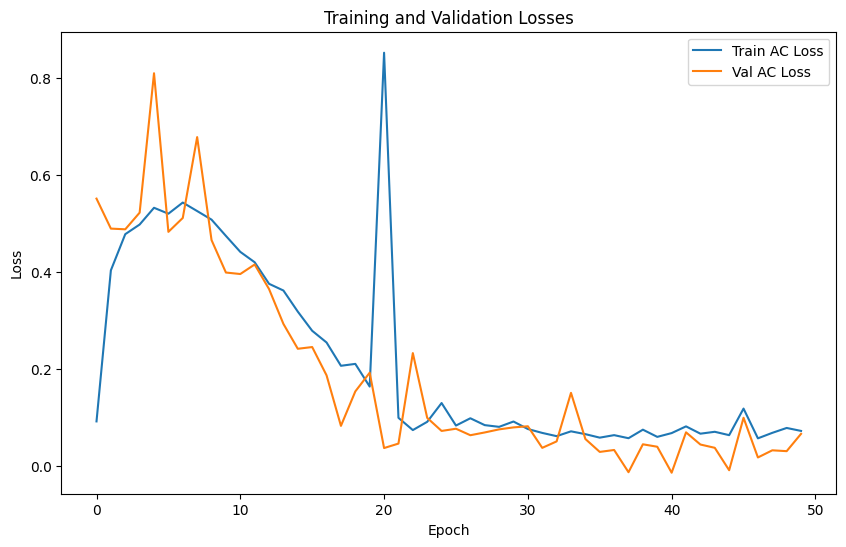

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(agent.training_ac_losses, label='Train AC Loss')
plt.plot(agent.val_ac_losses, label='Val AC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

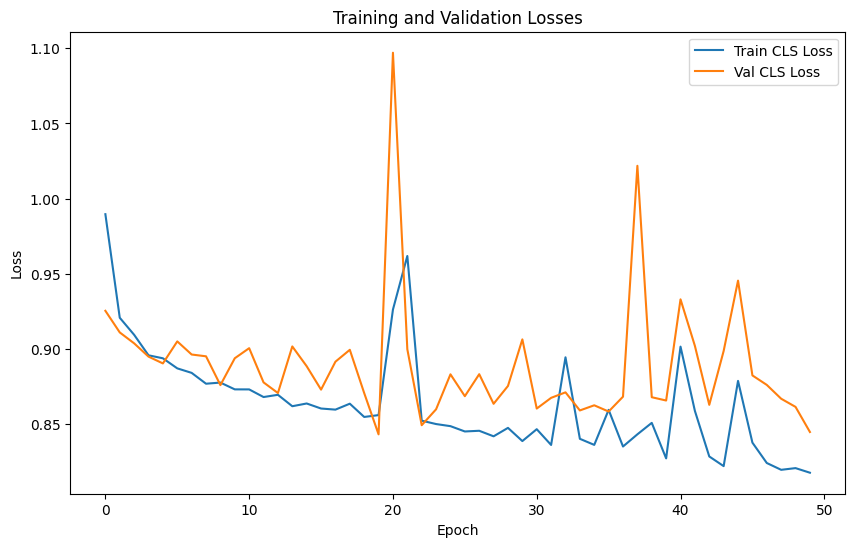

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(agent.training_classifier_losses, label='Train CLS Loss')
plt.plot(agent.val_classifier_losses, label='Val CLS Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

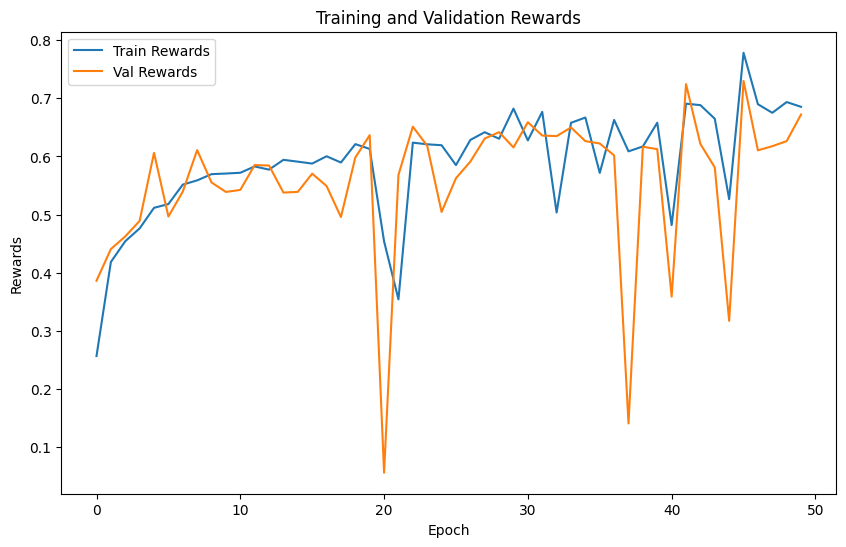

In [ ]:
training_rewards = torch.tensor(agent.training_rewards)
training_rewards.tolist()
plt.figure(figsize=(10, 6))
plt.plot(training_rewards.tolist(), label='Train Rewards')
plt.plot(torch.tensor(agent.val_rewards).cpu(), label='Val Rewards')
plt.xlabel('Epoch')
plt.ylabel('Rewards')
plt.title('Training and Validation Rewards')
plt.legend()
plt.show()

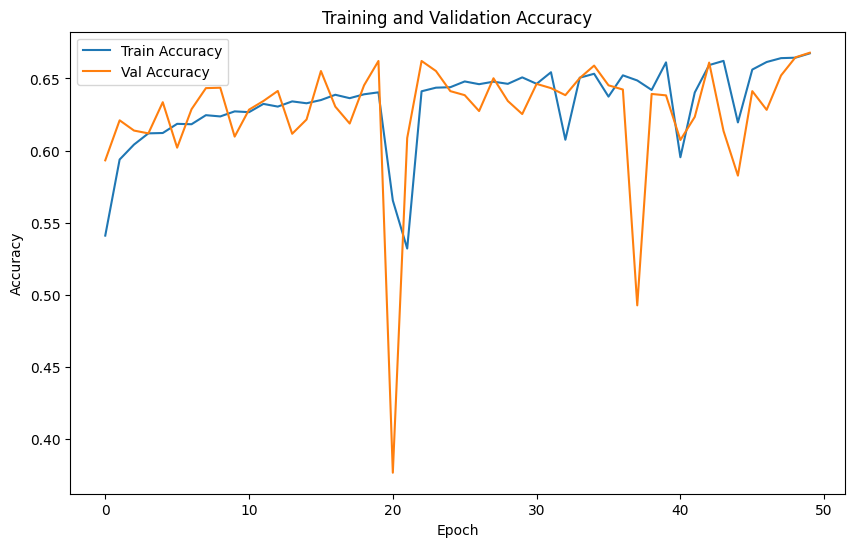

In [ ]:
training_accuracy = torch.tensor(agent.training_accuracies).cpu()
val_accuracy = torch.tensor(agent.val_accuracies).cpu()
plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [19]:
def evaluate_model(actor_model, critic_classifier_model, dataloader):
    actor_model.eval()
    critic_classifier_model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for i, data in enumerate(tqdm.tqdm(dataloader), 0):
            sentence_embedding = phobert(data[0].to(device), attention_mask=data[1].to(device))[0]
            policy = actor_model(sentence_embedding)
            action = torch.argmax(policy, dim=-1)
            filtered_sentence_embedding = sentence_embedding * action.unsqueeze(-1).float()
            _, classifier_preds = critic_classifier_model(filtered_sentence_embedding)
            preds.extend(classifier_preds.argmax(dim=-1).cpu().numpy())
            labels.extend(data[2].cpu().numpy())
    return preds, labels

actor_net.load_state_dict(torch.load('./Model/actor_model.pth'))
critic_classifier_net.load_state_dict(torch.load('./Model/critic_classifier_model.pth'))

test_preds, test_labels = evaluate_model(actor_net, critic_classifier_net, test_dataloader)
print(classification_report(test_labels, test_preds))

RuntimeError: Error(s) in loading state_dict for CriticClassifierNet:
	size mismatch for classifier.weight: copying a param with shape torch.Size([3, 64]) from checkpoint, the shape in current model is torch.Size([5, 64]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([5]).